# Demystifying Neural Networks 
### Let's write a (tiny but working) Neural Network library from scratch!

---

## Michal Grochmal <mike@grochmal.org>

### What do I do?

+ Teach Machine Learning at **City, University of London**
+ Do data munging - currently **looking** for extra employment

## PyCon UK 2019



<div style="text-align:right;font-size:0.7em;">crown-scaled.svg</div>

## Introduction

We will attempt to understand how neural networks (ANNs) work but we will attempt to understand
more than just their concepts - we will try to understand how they are implemented in code.
Most ANN libraries use vectorial computing to achieve reasonable training speed,
after all ANNs are particularly expensive to train.

ANN libraries speed things even more by using GPUs.
We cannot delve in a single talk into ANNs and into GPUs, that would be too much to cover.
That said, the majority of what the GPU provides is an vector/array data structure,
processing of which can be performed completely on the GPU side.
We will assume that the `numpy.array` structure may or may not exist inside a GPU
and use that simple array structure as if it was GPU accelerated.
In other words, we will use `numpy.array` instead of fancy GPU vector structures
yet and GPU structures will have a very similar API to `numpy.array`.
The changes to a GPU structure needed to build an ANN library are pretty much
the same changes that we will perform on top of `numpy.array`.

## Plan

We will divide our work in two parts,
in the first part we will attempt to understand ANNs and how we can build them
using available tools.
We will go as deep as building the ANN itself but we will still use
external tools to train our ANN.

+ First we are going through the **conceptual neural network**,
  most of us do know that already but we do need to cover this.

+ (*hands-on*) Next we will try to figure out how the ANN actually **passes data through itself**.
  Surprisingly this is very different from the conceptual ANN.

+ We will introduce the **pulsar dataset**, which we will use to test our work.

+ Quickly build a neural network using `pytorch`.
  Based on this we will have a baseline of what we want to achieve.

+ (*hands-on*) Build a **tiny network** which cannot be trained but will be the base of our work.
  The network fails to understand the pulsar dataset, yet it can evaluate it.

+ Introduce **how an ANN is trained**, conceptually.

+ (*hands-on*) Download and use `autograd`.
  The `autograd` package allows us to perform differentiation, needed in order to train our ANN.

+ Understand the **differentiation chain rule** that allows `autograd`
  to derivate complex functions.

+ Use `autograd` to differentiate our tiny ANN for the pulsars.

+ (*hands-on*) Use `autograd` to fully train another tiny ANN.

**PAUSE**

In the second part we will write a small version of `autograd` ourselves,
just about enough to train our ANN.
We need to first understand what `autograd` does before being capable
of writing an ANN training library.

+ We will understand how the chain rule can be simplified by a **graph**.

+ (*hands-on*) Instead of using `autograd`'s `numpy` we will write our own `numpy` wrapper.
  The wrapper will build a graph out of every operation performed using our `numpy`.

+ (*hands-on*) Build a **graphviz** representation of our graphs,
  which will serve us to understand how we will apply the chain rule.

+ Understand the **Jacobian vector product** (JVP),
  which can be used on every graph path to evaluate the full chain rule.

+ (*hands-on*) Add JVP's to each node of our `numpy` wrapper.
  Also, we will add a procedure which will walk our **graph backwards**
  calculating the JVP along the way.

+ Next we compare our tiny implementation to the `autograd` package.

+ (*hands-on*) We use our own `grad` implementation to train the tiny
  ANN we have previously built.

+ (*hands-on*) Finally we add some **syntactic sugar** to make our ANN library
  look similar to the layer classes in `pytorch`.



<div style="text-align:right;font-size:0.7em;">preparation.svg</div>

## WiFi

Since we just arrived here and probably need to download a bunch of things
we need a network connections.  There is free wifi in the Cardiff City Hall,
the page describing the connection is at:

> [https://www.visitcardiff.com/visitor-information/cardiff-free-wifi/][wifi]

[wifi]: https://www.visitcardiff.com/visitor-information/cardiff-free-wifi/

But that link is useless unless you actually do have a connection!

Therefore here is a summary:

+ The name of the network is **Cardiff Free WiFi**.
+ On many devices a [captive portal][captive] will open automatically,
  if it does not just open a browser and navigate to any website
  (and you will be redirected to the captive portal).
+ Fill the info in the captive portal and you're ready to go
  (no silly email confirmations here).

[captive]: https://en.wikipedia.org/wiki/Captive_portal

## Code

We will need a couple of things on everyone's machine in order to get code running.
The repository for the talk is at:

> [https://github.com/grochmal/nnag][repo]

The repository is comprised of several [Jupyter Notebooks][note],
containing both the presentations and exercises.
The said, if you are unfamiliar with the Jupyter notebook, that's fine.
All examples use `print` statements, instead of Jupyter's automatic echo,
to display the results.  If you do not feel comfortable with using Jupyter
feel free to go directly to the repository in a browser and then simply
copy and paste the code into a text file.

[repo]: https://github.com/grochmal/nnag
[note]: https://jupyter-notebook.readthedocs.io/en/stable/

We will make heavy use of [NumPy][numpy], and occasionally of [Pandas][pandas]
and [matplotlib][plot].  I'll explain the occasional `pandas` and `matplotlib`
and the most complicated uses of `numpy` array operations but familiarity with
the general `numpy` array is expected.

[numpy]: https://numpy.org/
[plot]: https://matplotlib.org/
[pandas]: https://pandas.pydata.org/

You are free to install the dependencies in any way you see fit.
Although, I'm running this presentation from within and [anaconda distribution][conda].
The distribution provides us with the majority of the libraries we will need.
Extra note: if installing Jupyter through `pip` make sure you have an available
install of [mathjax][] availablei, without it the equations will become mangled
(Linux and family have packages for this, it can be quite a pain to install on MS Windows).

[conda]: https://www.anaconda.com/distribution/
[mathjax]: https://www.mathjax.org/

Finally we will use two external libraries: [autograd][] and [pytorch][].
**DO NOT DOWNLOAD `pytorch` right now!**.  Installing `pytorch` takes a good amount
of time yet we will not be using it in any exercises.  `pytorch` is only used by me
to demonstrate what we want to achieve.  We do need to install `autograd` be it with
`pip install autograd` or `conda install autograd` (on anaconda).

[autograd]: https://github.com/HIPS/autograd
[pytorch]: https://pytorch.org/

## Mathematics

I'm trying to avoid a heavy hand in mathematics as much as I can
but, inevitably, we will need to deal with a good deal of equations
in order to understand why we are running the code we are.
We will talk about the equations in due time when they appear,
the knowledge I hope you may bring is about basic matrices and
some very basic calculus (the more advanced bits I'll go though).
Here is a small glossary of the symbols we will use:

$\vec{x}$ - we will use the physics notation for vectors,
a vector is an ordered collection of scalar values.

$W$ - we will write matrices in capital letters,
a matrix is an ordered collection of same length vectors.

$\vec{x} \cdot \vec{y}$ - the dot-product between vectors,
it is a sum of the product of the components between the vectors.

$W \cdot \vec{x}$ - we will use the dot-product between vector and matrices alike,
the dot-product is performed between all combinations of vectors on the left and on the right.

$W^T$ - is a matrix transpose where we switch the rows and columns of the matrix,
kind off as if we rotated it a quarter of a circle.

$\hat{y}$ - a *hat* variable is commonly ued to denote an estimate,
an output of a model is an estimate and is often described this way.

$\sum_i$ - the big sigma mean the summation of all quantities
across all values of the subscript variable (here $i$).

$\frac{d}{du}g(u)$ - the derivative of the function $g$ with relation to $u$.

$\frac{\partial}{\partial u}g(u, v)$ - the partial derivative of the function $g$ with relation to $u$,
i.e. the derivative of a function of more than a single variable.

$\nabla g(u, v)$ - the gradient of the function $g$,
the partial derivative against each parameter of $g$.

## References

- [Pulsar Dataset - UCI][1]
- [Autograd - HIPS][2]
- [pyTorch - Neural Network Tutorial][3]
- [Anaconda - Python Distribution][4]
- [Deep Learning - ANN Book][5]
- [Code Repository for this Talk - with some extras][6]
- [City ML Short Course - shameless marketing][7]

[1]: https://archive.ics.uci.edu/ml/datasets/HTRU2
[2]: https://github.com/HIPS/autograd
[3]: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
[4]: https://www.anaconda.com/distribution/
[5]: https://www.deeplearningbook.org/
[6]: https://github.com/grochmal/nnag
[7]: https://www.city.ac.uk/courses/short-courses/introduction-to-data-analysis-and-machine-learning-with-python

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('myxkcd')

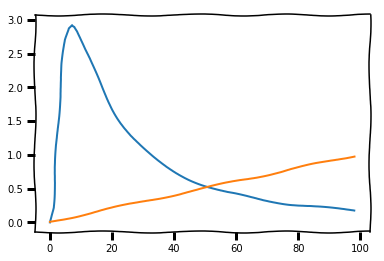

In [18]:
norm = np.arange(1, 100)/100
plt.plot((np.mean(norm)/np.sqrt(np.pi*2*norm**3))*np.exp(-(norm-np.mean(norm))**2/(2*norm)))
plt.plot(norm)



<div style="text-align:right;font-size:0.7em;">scratch.svg</div>